In [65]:
!pip install torch
!git clone https://github.com/ServiceNow/HighRes-net.git
!git clone https://github.com/xinntao/ESRGAN.git
!pip install rasterio

fatal: destination path 'HighRes-net' already exists and is not an empty directory.
fatal: destination path 'ESRGAN' already exists and is not an empty directory.


In [66]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import rasterio
from scipy.ndimage import convolve
from keras import models


In [67]:
esrgn_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(esrgn_path)

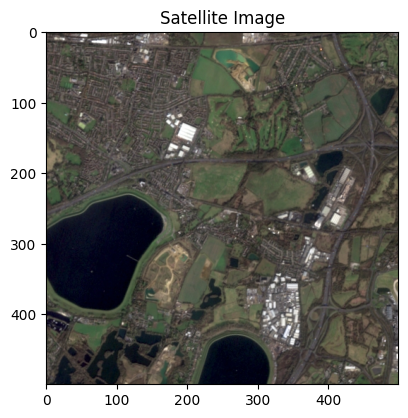

In [68]:
img = cv2.imread("/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Satellite Image')
plt.imshow(img[:, :, ::-1])

In [69]:
def preprocessing(img):
    imageSize = (tf.convert_to_tensor(img.shape[:-1]) // 4) * 4
    cropped_image = tf.image.crop_to_bounding_box(
        img, 0, 0, imageSize[0], imageSize[1])
    preprocessed_image = tf.cast(cropped_image, tf.float32)
    return tf.expand_dims(preprocessed_image, 0)

In [70]:
def srmodel(img):
    preprocessed_image = preprocessing(img)  # Preprocess the LR Image
    new_image = model(preprocessed_image)  # Runs the model
    # returns the size of the original argument that is given as input
    return tf.squeeze(new_image) / 255.0


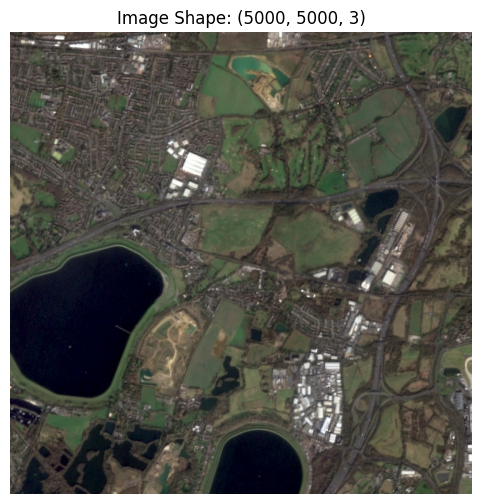

Pixel Range: 0 to 255
Super-resolution image saved successfully!


In [71]:
hr_image = srmodel(img)

# Remove batch dimension if present (e.g., (1, H, W, C) → (H, W, C))
if len(hr_image.shape) == 4:
    hr_image = tf.squeeze(hr_image, axis=0)

# Convert to NumPy
hr_image = hr_image.numpy()

# Normalize and convert to uint8 (Fix potential scaling issue)
hr_image = np.clip(hr_image * 255, 0, 255).astype(np.uint8)

# Resize AFTER converting to uint8
h, w = 5000, 5000
hr_image = cv2.resize(hr_image, (w, h), interpolation=cv2.INTER_CUBIC)

# Display image to check
plt.figure(figsize=(6,6))
plt.title(f"Image Shape: {hr_image.shape}")
plt.imshow(cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB))  # Ensure correct color format
plt.axis("off")
plt.show()

# Check min/max values
print("Pixel Range:", hr_image.min(), "to", hr_image.max())

# Save image correctly
cv2.imwrite('hr_image.jpg', hr_image)

print("Super-resolution image saved successfully!")

In [ ]:
# Load RGB satellite images
img_rgb = hr_image

print(img_rgb.shape)

# Open the LiDAR image using rasterio
with rasterio.open('/DSM_TQ0075_P_12757_20230109_20230315.tif') as lidar_src:
    depth = lidar_src.read(1)  # Read the first band (assuming single-band image)

depth = np.maximum(depth, 0)
img_up = np.zeros_like(img_rgb)
h, w = img_rgb.shape[:2]
for i in range(h):
    for j in range(w):
        print(i ,j)
        x1, x2 = max(0, j-1), min(w, j+2)
        y1, y2 = max(0, i-1), min(h, i+2)
        filter = depth[y1: y2, x1:x2] - depth[i, j]
        filter = np.abs(filter)
        filter = np.exp(-filter)
        filter[1, 1] = 0
        filter /= np.sum(filter)
        for c in range(3):
            img_up[i, j, c] = np.sum(img_rgb[y1:y2, x1:x2, c] * filter)
cv2.imwrite('out_nn.jpg', img_up)


流式输出内容被截断，只能显示最后 5000 行内容。
240 821
240 822
240 823
240 824
240 825
240 826
240 827
240 828
240 829
240 830
240 831
240 832
240 833
240 834
240 835
240 836
240 837
240 838
240 839
240 840
240 841
240 842
240 843
240 844
240 845
240 846
240 847
240 848
240 849
240 850
240 851
240 852
240 853
240 854
240 855
240 856
240 857
240 858
240 859
240 860
240 861
240 862
240 863
240 864
240 865
240 866
240 867
240 868
240 869
240 870
240 871
240 872
240 873
240 874
240 875
240 876
240 877
240 878
240 879
240 880
240 881
240 882
240 883
240 884
240 885
240 886
240 887
240 888
240 889
240 890
240 891
240 892
240 893
240 894
240 895
240 896
240 897
240 898
240 899
240 900
240 901
240 902
240 903
240 904
240 905
240 906
240 907
240 908
240 909
240 910
240 911
240 912
240 913
240 914
240 915
240 916
240 917
240 918
240 919
240 920
240 921
240 922
240 923
240 924
240 925
240 926
240 927
240 928
240 929
240 930
240 931
240 932
240 933
240 934
240 935
240 936
240 937
240 938
240 939
240 940
240 941
240 9

In [ ]:
"""# Load RGB satellite images
img_rgb = cv2.imread('/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg')
print(img_rgb.shape)"""

In [ ]:
"""# Load RGB Image (H, W, 3)
rgb_image = cv2.imread("/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg")  # (H, W, 3)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Load LiDAR Depth Image (H, W) - Make sure it's normalized
depth_norm = depth
depth_norm = depth.astype(np.float32) / 255.0  # Normalize to [0,1]

rgb_image = cv2.resize(rgb_image, depth_norm.shape[::-1], interpolation=cv2.INTER_CUBIC)

# Expand dimensions to match RGB channels (H, W, 1)
depth_norm = np.expand_dims(depth_norm, axis=-1)

print(depth_norm.shape, rgb_image.shape)

# Concatenate along the channel dimension (H, W, 4)
rgbd_input = np.concatenate((rgb_image, depth_norm), axis=-1)

# Convert to torch tensor and permute (N, C, H, W)
rgbd_input = torch.tensor(rgbd_input).permute(2, 0, 1).unsqueeze(0)  # (1, 4, H, W)

print(rgbd_input.shape)  # Expected: (1, 4, H, W)"""

In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming rgbd_input is the tensor created from your code
# Convert to numpy for easier plotting
rgbd_numpy = rgbd_input.squeeze(0).permute(1, 2, 0).numpy()

# Normalize RGB image to range [0, 1] for proper visualization
rgb_image = rgbd_numpy[:, :, :3] / 255.0  # Normalize RGB to [0,1]
depth_image = rgbd_numpy[:, :, 3]  # Depth channel remains in [0,1] range

# Plot the RGBD input
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot RGB Image
axes[0].imshow(rgb_image)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Plot Depth Image
axes[1].imshow(depth_image, cmap='gray')
axes[1].set_title('Depth Image')
axes[1].axis('off')

plt.show()
"""

In [ ]:
"""%cd ESRGAN"""

In [ ]:
"""!python test.py"""

In [ ]:
"""# # Load RGB Image (H, W, 3)
# rgb_image = cv2.imread("/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg")  # (H, W, 3)
# rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# # Open the LiDAR image using rasterio
# with rasterio.open('/DSM_TQ0075_P_12757_20230109_20230315.tif') as lidar_src:
#     depth = lidar_src.read(1)  # Read the first band (assuming single-band image)

# depth = depth.astype(np.float32) / np.max(depth)  # Normalize depth values

# # depth = np.maximum(depth, 0)
# img_nn = cv2.resize(img_rgb, depth.shape[::-1], interpolation=cv2.INTER_NEAREST)

# img_up = np.zeros_like(img_nn)
# h, w = img_nn.shape[:2]

# depth = np.expand_dims(depth, axis=-1)
# print(img_up.shape, depth.shape)

# rgbd_input = np.concatenate((img_up, depth), axis=-1)
# rgb_input = np.mean(rgbd_input, axis=-1, keepdims=True)

# # If you want to keep the result as 3 channels, you can expand dimensions to (H, W, 3)
# rgb_input = np.repeat(rgb_input, 3, axis=-1)  # Repeat the averaged values across the 3 channels

# print(rgb_input.shape)"""

In [54]:
"""# Load RGB Image (H, W, 3)
rgb_image = cv2.imread("/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg")  # (H, W, 3)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# # Open the LiDAR image using rasterio
with rasterio.open('/DSM_TQ0075_P_12757_20230109_20230315.tif') as lidar_src:
  depth = lidar_src.read(1)  # Read the first band (assuming single-band image)

depth = depth.astype(np.float32) / np.max(depth)  # Normalize depth values

depth = np.maximum(depth, 0)
img_nn = cv2.resize(rgb_image, depth.shape[::-1], interpolation=cv2.INTER_NEAREST)

img_up = np.zeros_like(img_nn)
h, w = img_nn.shape[:2]

depth = np.expand_dims(depth, axis=-1)
print(img_up.shape, depth.shape)

rgbd_input = np.concatenate((img_up, depth), axis=-1)
rgb_input = np.mean(rgbd_input, axis=-1, keepdims=True)

# # If you want to keep the result as 3 channels, you can expand dimensions to (H, W, 3)
rgb_input = np.repeat(rgb_input, 3, axis=-1)  # Repeat the averaged values across the 3 channels

#rgb_input = torch.tensor(rgb_input).float()

print(rgb_input.shape)

# # # If you're using a model on a GPU, move the tensor to the same device as your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#rgb_input = rgb_input.to(device)
#rgb_input = rgb_input.permute(2, 0, 1).unsqueeze(0)"""


(5000, 5000, 3) (5000, 5000, 1)
(5000, 5000, 3)


In [55]:
"""result = srmodel(rgb_input)
#

# Remove batch dimension if present (e.g., (1, H, W, C) → (H, W, C))
if len(result.shape) == 4:
    result = tf.squeeze(result, axis=0)

# Convert to NumPy
result = result.numpy()

# Normalize and convert to uint8 (Fix potential scaling issue)
result = np.clip(result * 255, 0, 255).astype(np.uint8)

# Resize AFTER converting to uint8
h, w = 5000, 5000
result = cv2.resize(result, (w, h), interpolation=cv2.INTER_CUBIC)

# Display image to check
plt.figure(figsize=(6,6))
plt.title(f"Image Shape: {result.shape}")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))  # Ensure correct color format
plt.axis("off")
plt.show()

# Check min/max values
print("Pixel Range:", result.min(), "to", result.max())

# Save image correctly
cv2.imwrite('result.jpg', result)

print("Super-resolution image saved successfully!")"""

ResourceExhaustedError: Graph execution error:

Detected at node rdb/concat defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[1,64,5000,5000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node rdb/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_restored_function_body_47525]